# Tensorflow

![img](https://lh3.googleusercontent.com/I1Dpp7I9RZIGl0rVMlPfnhfl-bkl_2uDHZwVC87BWmqtPaAs1irMWOdJxTmTEQJB-VGfLryCyHxqvyNchVIVLL-vqGrF3Q=s688)

В этом семинаре мы познакомимся с [Tensorflow](https://www.tensorflow.org/) и напишем на нём что-нибудь машинно-обучаемое.

__[Если вы работаете локально]__ Устанавливаем tensorflow:
* `pip install tensorflow` хватит на первое время
* Если вы хотите поддержку GPU или  TF специально собранный под ваш процессор, вам [сюда](https://www.tensorflow.org/install/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

# все вычисления в tf происходят в сессии: "сессия.посчитай_мне(вот_это)"
sess = tf.InteractiveSession()

### Разогрев: __numpy__ vs __tensorflow__

__Задание:__ напишите (на numpy) функцию, которая вычисляет __сумму квадратов чисел от 0 до `N - 1`__ (включительно).

_hint: numpy.arange_

In [3]:
def sum_squares_np(N):
    # сумма квадратов чисел от 0 до N - 1 
    result = np.sum([i * i for i in range(N)])
    return result 

In [4]:
%%time
sum_squares_np(10**8)

Wall time: 14.8 s


662921401752298880

Теперь напишем то же самое на TensorFlow.

In [5]:
# "место куда я потом подставлю чиселку N"
N = tf.placeholder('int64', name="my_input_N")

# "рецепт получения ответа, если у вас есть N"
result = tf.reduce_sum((tf.range(N)**2))

"Сессия, посчитай мне `result`. Подставь `N=10^8`"

In [6]:
%%time
print(sess.run(result, {N: 10**8}))

662921401752298880
Wall time: 478 ms


__hint:__ рецепты можно и нужно использовать повторно, подставляя разные входы. Начиная со второго вызова рецепт будет выполняется быстрее.

### Графы вычислений

Работа в TensorFlow состоит из двух частей: 

1. __создание графа__ вычислений (в примере выше: `N` и `result`)
2. использование этого графа для __вычислений__, уже с конкретными числами (sess.run(...))

Давайте разберёмся в каждом из них отдельно.

Создание графа вычислений обычно начинается с точек входа: __[tf.placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)__. Суть placeholder-ов: __"место, куда мы потом подставим данные"__.

In [7]:
# "сюда можно подставлять действительное число/вектор/тензор любого размера"
arbitrary_input = tf.placeholder('float32')

# "целочисленный вектор (1d) любой длины
input_vector = tf.placeholder('int32', shape=(None,))

# "только целочисленный вектор из 10 элементов"
fixed_size_vector = tf.placeholder('int32', shape=(10,))

# Смешанные варианты. если знаете размер заранее, указывайте. 
# если рамер может изменяться - оставляйте None. 
input1 = tf.placeholder('bool', shape=(None, 100, None))
input2 = tf.placeholder('int32', shape=(None, None, 3, 224, 224))

Далее вы можете писать операции _(рецепты)_, применяя функции к placeholder-ам, константам и результатам других операций.

Например, `tf.reduce_sum(tf.arange(N)\**2)` это три последовательных операции от N.

Синтаксис операций в tensorflow очень похож на numpy
  * Поэлементные операции: __`a + b, a / b, a ** b, ...`__
  * np.sin -> __tf.sin__
  * np.mean -> __tf.reduce_mean__
  * np.arange -> __tf.range__
  * np.zeros -> __tf.zeros__
  * np.random.randn -> __tf.random_normal__
  
После применения операции у вас получится новый тензор ([`tf.Tensor`](https://www.tensorflow.org/api_docs/python/tf/Tensor)) - узел графа вычислений, который можно использовать в новых операциях. 
Да, кстати, `tf.placeholder` это тоже тензор.
  
Полный список операций можно найти в [доках](https://www.tensorflow.org/api_docs/python), но пока лучше просто полагайтесь на __tab__ и __shift+tab__.

In [8]:
# операция "умножь каждый элемент на 2"
double_the_vector = input_vector * 2

# косинус поэлементной суммы
elementwise_cosine = tf.cos(tf.to_float(input_vector + fixed_size_vector))

# ещё пример
noise = tf.random_normal(tf.shape(arbitrary_input))
output = arbitrary_input ** 2 - tf.reduce_mean(arbitrary_input) * noise


А теперь вы можете использовать получившийся граф операций, чтобы что-нибудь посчитать.

  * __```sess.run(output_or_outputs, {placeholder1: value1, placeholder2: value2})```__ - рекомендованный способ.
  * __```output.eval({placeholder:value})```__ - для отладки, вычисляет один тензор (число, вектор, матрицу, ...) в [дефолтной сессии](https://www.tensorflow.org/api_docs/python/tf/get_default_session).
  

In [9]:
print('output on scalar', sess.run(output, {arbitrary_input: 3.1415926}))
print('output on vector', sess.run(output, {arbitrary_input: np.ones(5)}))

output on scalar 12.471414
output on vector [-0.44640684  0.9512577   0.69328773  1.5028572   2.0142827 ]


__Hint:__ если у вас несколько связанных выходов, лучше вычислять их вместе, чтобы избежать повторных вычислений:
  * ```a, b = sess.run([output1, output2], {placeholder: value})```
  * ```a_dict, b = sess.run(({'a': output1, 'b': output2}, output3), {placeholder:value})```

### Задание 1: polar pretzels
_inspired by [this post](https://www.quora.com/What-are-the-most-interesting-equation-plots)_

Есть в тригонометрии класс функций с забавными графиками. Вот пример:

$$ x(t) = t - 1.5 * cos( 15 t) $$
$$ y(t) = t - 1.5 * sin( 16 t) $$

__задание:__ реализуйте вычисление этой функции на tensorflow (см. ниже)


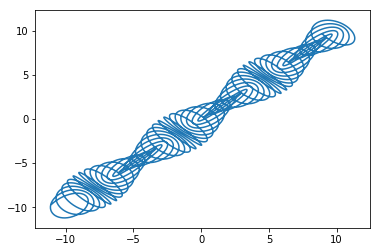

In [10]:
t = tf.placeholder('float32')


x = t - 1.5 * tf.cos(15 * t)
y = t - 1.5 * tf.sin(16 * t)


x_points, y_points = sess.run([x, y], {t: np.linspace(-10, 10, num=10000)})
plt.plot(x_points, y_points);

Если вы уже выполнили задание, предлагаем
* поиграться с параметрами кренделя
* работа с размерностями в TF - [тут](https://gist.github.com/justheuristic/138fde49b32ec59f2d80298f6959d5ab#file-md)
* визуализация TFных графов - [тут](https://gist.github.com/justheuristic/138fde49b32ec59f2d80298f6959d5ab#file-tensorboard-md)


А ещё есть длинная, но очень клёвая подборка советов [effective tensorflow](https://github.com/vahidk/EffectiveTensorflow#effective-tensorflow) - но лучше читать его уже после семинара.

### Задание 2: mean squared error
Вычислите MSE по 2 векторам. На этот раз вам нужно написать не только граф, но и само вычисление.

In [11]:
#  v--- постройте граф (placeholder-ы и операции, которые вычисляют MSE)
# <...>


def compute_my_mse(y_target, y_predicted):
    a = tf.placeholder('float32')
    b = tf.placeholder('float32')
    
    mse = tf.reduce_mean(tf.square(a - b))
    
    return sess.run(mse, {a: y_target, b: y_predicted})
#     return <вычислите mse для конкретных входов, используя sess.run>


In [38]:
# Тесты
from sklearn.metrics import mean_squared_error

for n in [1, 5, 10, 10 ** 3]:
    
    elems = [np.arange(n), np.arange(n,0,-1), np.zeros(n),
             np.ones(n), np.random.random(n), np.random.randint(100,size=n)]
    
    for el in elems:
        for el_2 in elems:
#             print(el, el_2)
            true_mse = np.array(mean_squared_error(el, el_2))
            my_mse = compute_my_mse(el, el_2)
            if not np.allclose(true_mse, my_mse):
                print('Ошибка:')
                print('mse(%s,%s)' % (el,el_2))
                print("должно быть: %f, получилось: %f" % (true_mse, my_mse))
                raise ValueError("Что-то не так")

print("Все тесты пройдены!")    

Все тесты пройдены!


# Переменные (Variables)

[`tf.placeholder`](https://www.tensorflow.org/api_docs/python/tf/placeholder)-ы удобны, когда вы хотите подставлять новые данные в ваш граф при каждом вызове ```sess.run```. Если вы хотите, чтобы какая-то переменная всегда имела значение (например, веса нейронной сети), которое вы могли бы изменять когда сочтёте нужным, для вас есть переменные [`(tf.Variable)`](https://www.tensorflow.org/api_docs/python/tf/placeholder).

* Переменные сами хранят численное значение;
* Вы можете в любой момент изменить значение переменной;
* Переменные можно использовать в операциях, также как и placeholder-ы.
 
Больше про то, как работают переменные - [тык](https://www.tensorflow.org/guide/variables).

In [40]:
# создать новую переменную
my_variable = tf.Variable(initial_value=np.arange(5, dtype='float32'))

# операция над переменной
variable_squared = my_variable ** 2

# присвоить всем переменным их initial_value
sess.run(tf.global_variables_initializer())

In [41]:
print("value :", sess.run(my_variable))
print("square:", sess.run(variable_squared))

value : [0. 1. 2. 3. 4.]
square: [ 0.  1.  4.  9. 16.]


In [42]:
# задать значение переменной вручную
sess.run(my_variable.assign(np.arange(5, 10, 1)))

print("value :", sess.run(my_variable))
print("square:", sess.run(variable_squared))

value : [5. 6. 7. 8. 9.]
square: [24.999998 36.       48.999996 64.       81.      ]


### Автоматичекие градиенты
* Tensorflow может автоматически считать для вас частные производные: __```tf.gradients(f(x), [x])```__
* Для этого он проходит по операциям, участвовавшим в вычислении целевого значения, и применяет chain rule, например
$$ {\partial \text{tf.exp}(\text{tf.cos}(x)) \over \partial x} = {\partial \text{tf.exp}(\text{tf.cos}(x)) \over \partial \text{tf.cos}(x)}\cdot {\partial \text{tf.cos}(x) \over \partial x} $$

* Производные всех элементарных функций (tf.exp, tf.cos, tf.reduce_sum) подставляются автоматически.

Таким образом вы можете посчитать производную любого скалярного значения по любому тензору, участвующему в его вычислении. 

_Давайте поиграемся :)_

In [4]:
my_scalar = tf.placeholder('float32')

scalar_squared = my_scalar ** 2

#a derivative of scalar_squared by my_scalar
derivative = tf.gradients(scalar_squared, [my_scalar])[0]

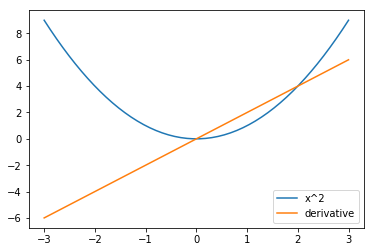

In [6]:
x = np.linspace(-3,3)
x_squared, x_squared_der = sess.run([scalar_squared, derivative], {my_scalar:x})

plt.plot(x, x_squared,label="x^2")
plt.plot(x, x_squared_der, label="derivative")
plt.legend();

### Почему это круто

Ниже определена функция __`weird_psychotic_function`__ от __`my_scalar`__ и __`my_vector`__. Что она делает... ой, вам лучше не знать.

__ваша задача:__ вычислить производную этой функции по обоим аргументам.

In [7]:
my_vector = tf.placeholder('float32',[None])

weird_psychotic_function = tf.reduce_mean((my_vector+my_scalar)**(1+tf.nn.moments(my_vector,[0])[1]) + 1./ tf.atan(my_scalar))/(my_scalar**2 + 1) + 0.01*tf.sin(2*my_scalar**1.5)*(tf.reduce_sum(my_vector)* my_scalar**2)*tf.exp((my_scalar-4)**2)/(1+tf.exp((my_scalar-4)**2))*(1.-(tf.exp(-(my_scalar-4)**2))/(1+tf.exp(-(my_scalar-4)**2)))**2

# посчитайте производную функции по my_scalar и my_vector
der_by_scalar = tf.gradients(weird_psychotic_function, [my_scalar])[0]
der_by_vector = tf.gradients(weird_psychotic_function, [my_vector])[0]

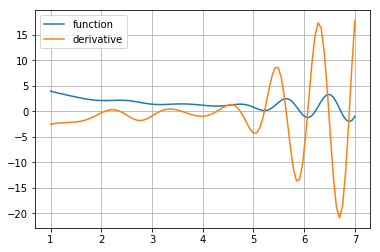

In [8]:
scalar_space = np.linspace(1, 7, 100)

y = [sess.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y, label='function')

y_der_by_scalar = [sess.run(der_by_scalar, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend();

### Последний штрих: оптимизаторы (Optimizer)

Чтобы вам не приходилось писать шаг градиентного спуска вручную, в TensorFlow есть зоопарк алгоритмов на оптимизации: [__`tf.train`__](https://www.tensorflow.org/api_guides/python/train). 

Кроме обычного SGD там есть rmsprop, adam и все-все-все - shift+tab вам в помощь.

In [97]:
y_guess = tf.Variable(np.zeros(2,dtype='float32'))
y_true = tf.range(1,3,dtype='float32')

loss = tf.reduce_mean((y_guess - y_true + tf.random_normal([2]))**2) 

optimizer = tf.train.MomentumOptimizer(0.05, 0.5).minimize(loss, var_list=y_guess)

# те же градиенты, более подробно
# updates = [[tf.gradients(loss,y_guess)[0], y_guess]]
# optimizer = tf.train.MomentumOptimizer(0.05, 0.5).apply_gradients(updates)

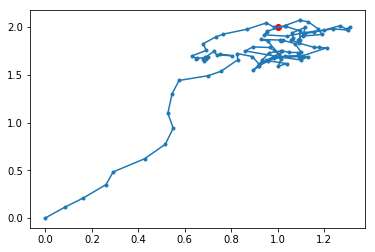

In [98]:
from IPython.display import clear_output

sess.run(tf.global_variables_initializer())

guesses = [sess.run(y_guess)]

for _ in range(100):
    sess.run(optimizer)
    guesses.append(sess.run(y_guess))
    
    clear_output(True)
    plt.plot(*zip(*guesses), marker='.')
    plt.scatter(*sess.run(y_true), c='red')
    plt.show()

# Реализуем логистическую регрессию

Прежде чем мы перейдём к нейросетям, давайте реализуем на tensorflow логистическую регрессию. Обучим её отличать рукописные "0" от "1".

Если вы не помните, как работает логистическая регрессия, ~~что вы вообще здесь делаете?~~ не бойтесь, мы всё напомним.

In [14]:
from sklearn.datasets import load_digits
X, y = load_digits(2, return_X_y=True)

print("y [shape - %s]:" % (str(y.shape)), y[:10])
print("X [shape - %s]:" % (str(X.shape)))

y [shape - (360,)]: [0 1 0 1 0 1 0 0 1 1]
X [shape - (360, 64)]:


X:
 [[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0.]
 [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.]
 [ 0.  0.  1.  9. 15. 11.  0.  0.  0.  0.]]
y:
 [0 1 0 1 0 1 0 0 1 1]


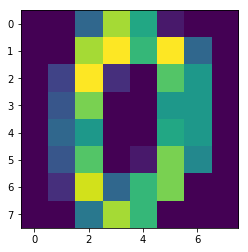

In [15]:
print('X:\n', X[:3,:10])
print('y:\n', y[:10])
plt.imshow(X[0].reshape([8,8]))

Объявим placeholder-ы для X и y.

In [16]:
input_X = tf.placeholder('float32', shape=(None, 64))
input_y = tf.placeholder('float32')

In [17]:
# объявим переменную с весами. Начальное значение - 64 нуля (вектор)
weights = tf.Variable(np.zeros([64, 1], dtype='float32'))

sess.run(tf.global_variables_initializer())

Поскольку это бинарная классификация, будем учить лог-регрессию с сигмоидой:
$$P(y_i | X_i) = \sigma(W \cdot X_i) ={ 1 \over {1+e^{- [W \cdot X_i]}} }$$

hint: скалярное произведение $[W \cdot X_i]$ можно посчитать при помощи `*` и [`tf.reduce_sum`](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), а можно запариться и использовать [`tf.matmul`](https://www.tensorflow.org/api_docs/python/tf/matmul).

In [18]:
predicted_y_proba = 1 / (1 + tf.exp(-tf.reduce_sum(tf.matmul(input_X, weights), axis=1)))
# predicted_y_proba = tf.reshape(1 / (1 + tf.exp(-tf.matmul(input_X, weights))), (1, ))
print(predicted_y_proba.shape)
assert predicted_y_proba.shape.ndims == 1, "class 1 probabilities must be 1-dimentional. consider [:, 0]"

(?,)


В качестве функции потерь возьмём logloss (aka binary crossentropy, -log(likeihood)):
$$ L = {1 \over N} \underset{X_i,y_i} \sum - [  y_i \cdot log P(y_i | X_i) + (1-y_i) \cdot log (1-P(y_i | X_i)) ]$$

Не забудьте минус :)

In [19]:
# logistic loss (scalar, mean over sample) between predicted_y_proba and input_y
loss = tf.reduce_mean(-(input_y * tf.log(predicted_y_proba) + (1-input_y) * tf.log(1-predicted_y_proba)))

# теперь можно позвать tf.train.GradientDescentOptimizer как в примере выше.
# train_step = tf.train.MomentumOptimizer(0.05, 0.5).minimize(loss, var_list=weights)
train_step = tf.train.AdamOptimizer(0.01, 0.5).minimize(loss, var_list=weights)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

loss at iter 0: 0.6931
train auc: 1.0
test auc: 1.0
loss at iter 1: 0.3347
train auc: 1.0
test auc: 1.0
loss at iter 2: 0.2054
train auc: 1.0
test auc: 1.0
loss at iter 3: 0.1031
train auc: 1.0
test auc: 1.0
loss at iter 4: 0.0797
train auc: 1.0
test auc: 1.0
resulting weights:


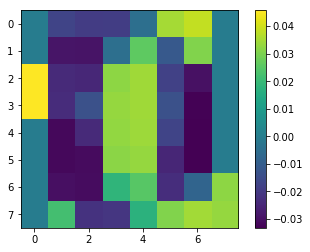

In [23]:
from sklearn.metrics import roc_auc_score
sess.run(tf.global_variables_initializer())
for i in range(5):
    
    loss_i, _ = sess.run([loss, train_step], {input_X: X_train, input_y: y_train})###<YOUR CODE: feed values to placeholders>)
    
    print("loss at iter %i: %.4f" % (i, loss_i))
#     print(sess.run(predicted_y_proba, {input_X: X_train}))
    print("train auc:", roc_auc_score(y_train, sess.run(predicted_y_proba, {input_X: X_train})))
    print("test auc:", roc_auc_score(y_test, sess.run(predicted_y_proba, {input_X: X_test})))

    
print ("resulting weights:")
plt.imshow(sess.run(weights).reshape(8, -1))
plt.colorbar();


```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```



### Дошли досюда?

Значит либо вы очень круты и задания показались вам простыми, либо вы решили более подробно изучить тетрадку уже после семинара... ну либо вы просто случайно сюда промотали. В последнем случае прошу промотать обратно к нерешённым заданиям.


Всё ещё читаете? Тогда вы сами виноваты. Будем учить многослойную нейронку.


Сегодня в меню mnist - распознавание рукописных цифр. Но вы, вероятно, уже их где-то видели.
* ч/б картинки 28x28 пикселей = 784 признака
* 10 классов
* 50k примеров для обучения

Ваша задача - научить `хотя_бы_двухслойный_персептрон`, который будет их классифицировать

Линейные модели на этой задаче ошибаются чуть больше, чем в __7% случаев__.

__Ваша задача:__ сократить долю ошибок хотя бы до __3%__. 

Если слова "свёрточная нейросеть" вам о чём-то говорят - сразу до 1%.


In [3]:
!wget https://gist.github.com/justheuristic/783144a0c0e82d829707c69240965fa9/raw/39b81ca7f8c3f4f3ce4c980540b25dc858de3020/mnist.py -O mnist.py
from mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

print (X_train.shape, y_train.shape)

'wget' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


(50000, 28, 28) (50000,)


TypeError: Invalid dimensions for image data

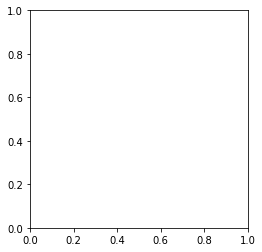

In [4]:
plt.imshow(X_train[0,0])

вы чувствуете необъяснимое желание создавать placeholder-ы и переменные в этой клетке

что-то подсказывает вам, что ваша нейросеть должна уметь предсказывать вероятности классов

вы вспоминаете, что можно обучаться на multiclass log loss (aka categorical crossentropy

вы чувствуете, что вам потребуется цикл с многими итерациями обучения. голоса в голове шепчут "используй минибатчи!"

вам кажется, что было бы неплохо отслеживать качество модели на отдельной выборке

только сейчас вы вспоминаете, что у вас есть ещё и тестовая выборка. почему бы не померить точность на ней?